In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:35229 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
db = '/scratch/e14/rmh561/access-om2/archive/databases/cc_database_omip'
session = cc.database.create_session(db)

In [4]:
exptdict = OrderedDict([
    ('1 OMIP2 cycle 1',  {'expt':'1deg_jra55_iaf_omip2'}),
    ('1 OMIP2 cycle 2',  {'expt':'1deg_jra55_iaf_omip2_cycle2'}),
    ('1 OMIP2 cycle 3',  {'expt':'1deg_jra55_iaf_omip2_cycle3'}),
    ('1 OMIP2 cycle 4',  {'expt':'1deg_jra55_iaf_omip2_cycle4'}),
    ('1 OMIP2 cycle 5',  {'expt':'1deg_jra55_iaf_omip2_cycle5'}),
    ('1 OMIP2 cycle 6',  {'expt':'1deg_jra55_iaf_omip2_cycle6'}),
    ('025 OMIP2 cycle 1',   {'expt':'025deg_jra55_iaf_cycle1'}),
    ('025 OMIP2 cycle 2',   {'expt':'025deg_jra55_iaf_cycle2'}),
    ('025 OMIP2 cycle 1 oldtopo',  {'expt':'025deg_jra55_iaf_newIC'}),   
    ('025 RYF',   {'expt':'025deg_jra55_ryf9091_gadi'}),
])

## Just checking the final data for each expt.

In [5]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,ncfile='ocean_scalar.nc')
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to %d'% (start_year, end_year))
    
end_time = '2019-01-01'
print(' Setting end_time to',end_time)

1deg_jra55_iaf_omip2 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle2 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle3 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle4 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle5 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle6 goes from 1958 to 2018
025deg_jra55_iaf_cycle1 goes from 1958 to 2018
025deg_jra55_iaf_cycle2 goes from 1958 to 2018
025deg_jra55_iaf_newIC goes from 1958 to 2017
025deg_jra55_ryf9091_gadi goes from 1900 to 2499
 Setting end_time to 2019-01-01


## Scalar diagnostics

In [6]:
def plot_timeseries(variable,end_time,keys=exptdict.keys(),ncfile=None):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,end_time=end_time,ncfile=ncfile)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 15.8 s, sys: 334 ms, total: 16.2 s
Wall time: 26.7 s


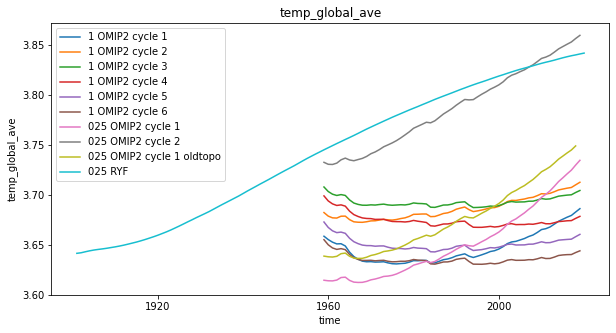

In [7]:
%%time
plot_timeseries('temp_global_ave',end_time,ncfile='ocean_scalar.nc')

### Global Average Salinity

CPU times: user 14.9 s, sys: 403 ms, total: 15.3 s
Wall time: 24.3 s


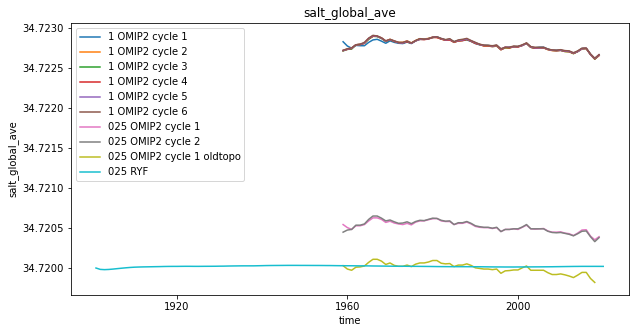

In [8]:
%%time
plot_timeseries('salt_global_ave',end_time,ncfile='ocean_scalar.nc')

### Surface Temperature

CPU times: user 4min 8s, sys: 6.56 s, total: 4min 15s
Wall time: 5min 46s


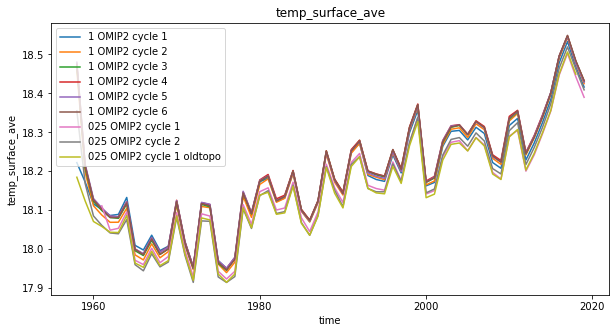

In [10]:
%%time
keys = ['1 OMIP2 cycle 1','1 OMIP2 cycle 2','1 OMIP2 cycle 3','1 OMIP2 cycle 4','1 OMIP2 cycle 5','1 OMIP2 cycle 6','025 OMIP2 cycle 1','025 OMIP2 cycle 2','025 OMIP2 cycle 1 oldtopo']
plot_timeseries('temp_surface_ave',end_time,keys,ncfile='ocean_scalar_snapshot.nc')

### Surface Salinity

CPU times: user 16.1 s, sys: 638 ms, total: 16.7 s
Wall time: 27.4 s


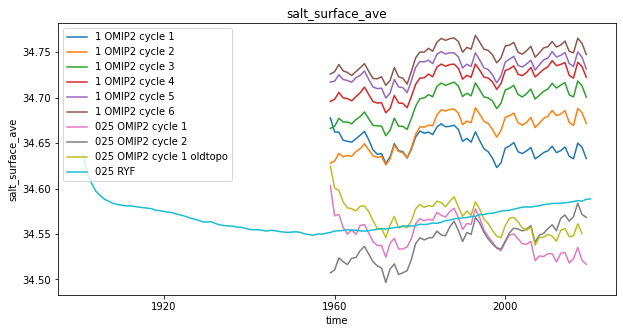

In [11]:
%%time
plot_timeseries('salt_surface_ave',end_time,ncfile='ocean_scalar.nc')

### Total Kinetic Energy

CPU times: user 15.5 s, sys: 515 ms, total: 16 s
Wall time: 25.7 s


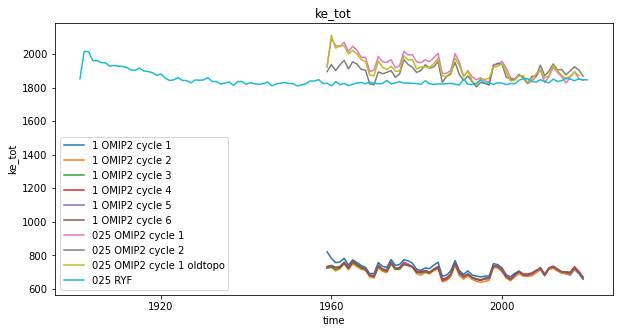

In [12]:
%%time
plot_timeseries('ke_tot',end_time,ncfile='ocean_scalar.nc')

## Area-Averaged Tracer Diagnostics

In [11]:
def plot_depthintv(variable,end_time,zlims,keys=exptdict.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        area = cc.querying.getvar(expt,'area_t',session,n=1)
        dzt = cc.querying.getvar(expt,'dht',session,n=1).isel(time=0)
        vol = (dzt*area).sel(st_ocean = slice(zlims[0],zlims[1]))
        var = var.sel(st_ocean = slice(zlims[0],zlims[1]))
        varmean = ((var*vol).sum('st_ocean').sum('yt_ocean').sum('xt_ocean')/(vol.sum('st_ocean').sum('yt_ocean').sum('xt_ocean'))).resample(time='Y').mean()
        (varmean-273.15).plot(label=ekey)
    plt.legend()
    plt.title(str(zlims[0]) + ' - ' + str(zlims[1]) + 'm ' + variable)

### Upper 700m temp

In [12]:
%%time
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2','1 OMIP2 cycle 1','1 OMIP2 cycle 2']
plot_depthintv('pot_temp',end_time,[0.,700.],keys=keys)

025deg_jra55_iaf_cycle1


distributed.core - ERROR - 'tcp://127.0.0.1:33411'
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/core.py", line 597, in handle_stream
    handler(**merge(extra, msg))
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/scheduler.py", line 2684, in handle_release_data
    ws = self.workers[worker]
KeyError: 'tcp://127.0.0.1:33411'
distributed.utils - ERROR - 'tcp://127.0.0.1:33411'
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/scheduler.py", line 1813, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site

KilledWorker: ("('sum-1bf9743943199829327fe71cb65aea33', 496, 0, 4, 0)", <Worker 'tcp://127.0.0.1:37103', name: 15, memory: 0, processing: 42464>)

<Figure size 720x360 with 0 Axes>

### Upper 2000m temp

025deg_jra55_iaf_cycle1


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_cycle2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
CPU times: user 36min 21s, sys: 3min 15s, total: 39min 36s
Wall time: 41min 12s


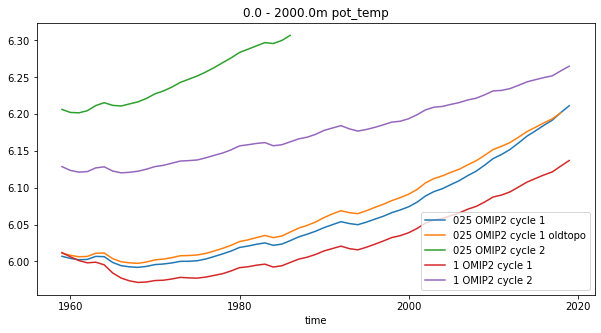

In [13]:
%%time
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2','1 OMIP2 cycle 1','1 OMIP2 cycle 2']
plot_depthintv('pot_temp',end_time,[0.,2000.],keys=keys)

### 2000m-bottom temp

In [ ]:
%%time
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2','1 OMIP2 cycle 1','1 OMIP2 cycle 2']
plot_depthintv('pot_temp',end_time,[2000.,10000.],keys=keys)

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


### Plots to make (XXXX):
- Temperature and salinity drifts compared to WOA13

## Circulation Diagnostics

### Drake Passage Transport

1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
1deg_jra55_iaf_omip2_cycle3
1deg_jra55_iaf_omip2_cycle4
1deg_jra55_iaf_omip2_cycle5
1deg_jra55_iaf_omip2_cycle6
025deg_jra55_iaf_cycle1
025deg_jra55_iaf_cycle2
025deg_jra55_iaf_newIC
025deg_jra55_ryf9091_gadi
CPU times: user 56.5 s, sys: 2.36 s, total: 58.9 s
Wall time: 2min 57s


Text(0.5, 1.0, 'ACC Transport')

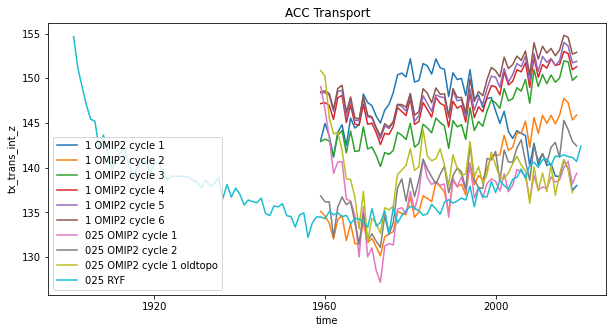

In [13]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
1deg_jra55_iaf_omip2_cycle3
1deg_jra55_iaf_omip2_cycle4
1deg_jra55_iaf_omip2_cycle5
1deg_jra55_iaf_omip2_cycle6
025deg_jra55_iaf_cycle1
025deg_jra55_iaf_cycle2
025deg_jra55_iaf_newIC
025deg_jra55_ryf9091_gadi
GM term not found
CPU times: user 9min 51s, sys: 21.1 s, total: 10min 12s
Wall time: 19min 21s


Text(0.5, 1.0, 'AABW Cell')

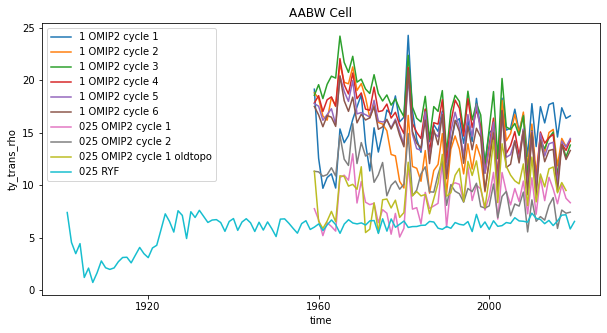

In [14]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,end_time=end_time)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
1deg_jra55_iaf_omip2_cycle6
025deg_jra55_iaf_cycle1
025deg_jra55_iaf_cycle2
025deg_jra55_iaf_newIC
CPU times: user 3min 29s, sys: 6.91 s, total: 3min 36s
Wall time: 6min 55s


Text(0.5, 1.0, 'AMOC Cell')

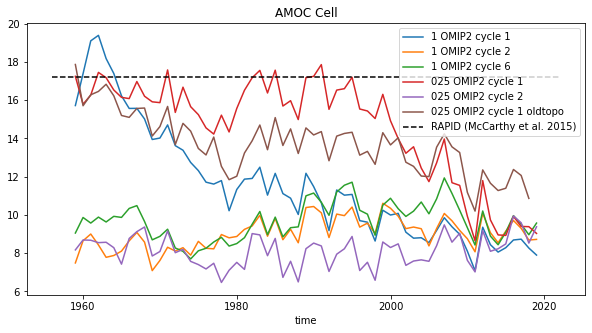

In [17]:
%%time
keys = ['1 OMIP2 cycle 1','1 OMIP2 cycle 2','1 OMIP2 cycle 6','025 OMIP2 cycle 1','025 OMIP2 cycle 2','025 OMIP2 cycle 1 oldtopo']
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,end_time=end_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
xlims = plt.xlim()
plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell')

### Indonesian Throughflow

1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
1deg_jra55_iaf_omip2_cycle3
1deg_jra55_iaf_omip2_cycle4
1deg_jra55_iaf_omip2_cycle5
1deg_jra55_iaf_omip2_cycle6
025deg_jra55_iaf_cycle1
025deg_jra55_iaf_cycle2
025deg_jra55_iaf_newIC
025deg_jra55_ryf9091_gadi
CPU times: user 50.9 s, sys: 1.67 s, total: 52.6 s
Wall time: 2min 3s


Text(0.5, 1.0, 'Indonesian Throughflow (115E)')

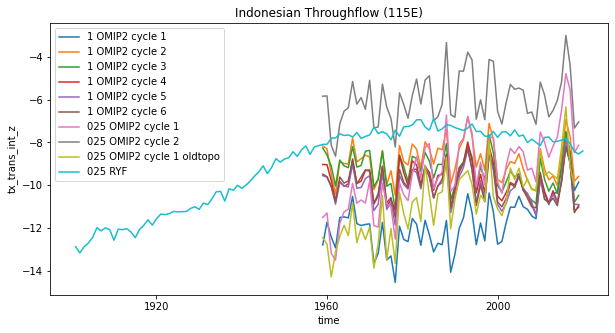

In [16]:
%%time

xmin=115.0-360.
ymin=-22.
ymax=-8.25

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("Indonesian Throughflow (115E)")

### Plots to make (XXXX):
- GMOC minimum at 30S.
- Meridional heat transport
- Eastern Pacific zonal velocity
- OHC anomalies + sea level rise - but probably not worth it until last cycle for drift reasons.
- Some sea ice metrics?

## Global Overturning Streamfunction

In [6]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

1deg_jra55_iaf_omip2
025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_ryf9091_gadi
GM term not found


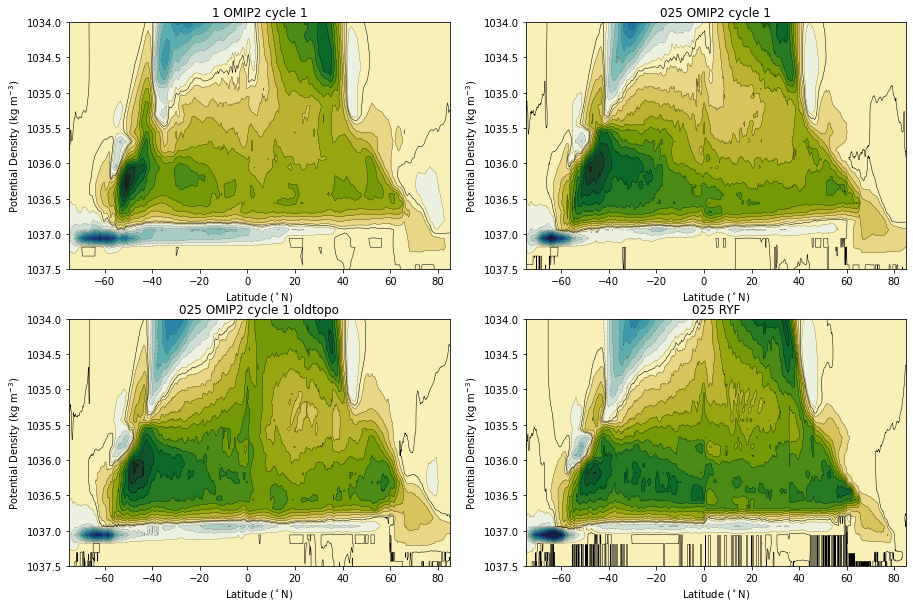

In [8]:
plt.figure(figsize=(15,10))
ii=0
keys = ['1 OMIP2 cycle 1','025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 RYF']
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time='2017-01-01',end_time='2018-01-01')
    psi = var.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time='2017-01-01',end_time='2018-01-01')
        psi_gm = var2.mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

### Ice Area (in both hemispheres)

025deg_jra55_ryf9091_gadi
025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_cycle2


Text(0.5, 1.0, 'Southern Ocean')

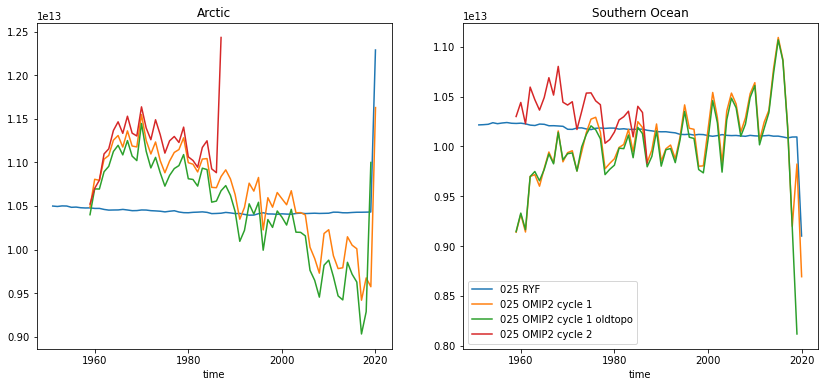

In [11]:
variable='aice_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
keys = ['025 RYF','025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2']
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').resample(time='Y').mean().load()
    NH_area.isel(time=slice(0,-1)).plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').resample(time='Y').mean().load()
    SH_area.isel(time=slice(0,-1)).plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

025deg_jra55_ryf9091_gadi
025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_cycle2


Text(0.5, 1.0, 'Southern Ocean')

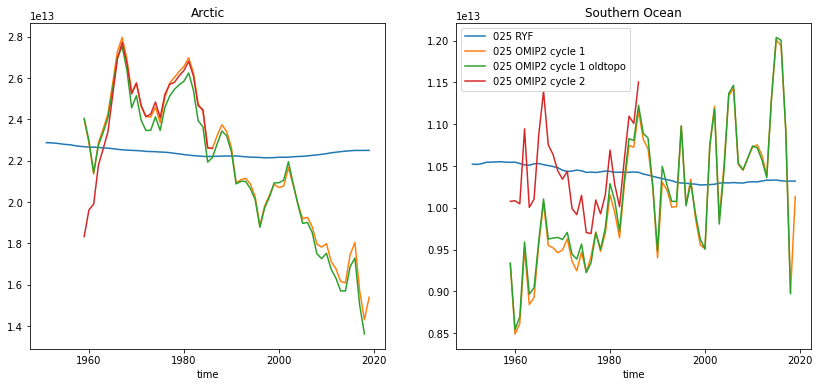

In [6]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
keys = ['025 RYF','025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','025 OMIP2 cycle 2']
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').resample(time='Y').mean().load()
    NH_vol.isel(time=slice(0,-1)).plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').resample(time='Y').mean().load()
    SH_vol.isel(time=slice(0,-1)).plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

## Issues that I ran into:

### Potential vs. Conservative Temperature

- SST should be potential temperature - as this is what goes into the bulk formula.

- `bottom_pot_temp`, `pot_temp_surface_ave`, `pot_temp_global_ave` diagnostics don't exist - must be calculated offline. Note: `surface_ave` differences are negligible by construction. `pot_temp_global_ave` should not be used in a TEOS-10 model (not related to heat content).

- Out of range issues on diagnostic squared potential temperature output created GB-sized `.err` text files.

- Note: new McDougall manuscript will advocate for interpreting potential temperature of EOS-80 models as Conservative Temperature (as it is assumed to be conserved in these models). In TEOS-10 models Conservative Temperature should be used for all heat content calculations (except that SST variables should be potential temperature).

### Numerical issues

- New topography – needed to add Rayleigh drag in Kara Strait to avoid ice CFL issues. Still ended up using `dt=1350s` not `1800s`.

- Ice thermo errors – had to drop the time step to `900s` twice in cycle 1, and once (so far) in cycle 2. This was an issue in the 1/10th - fixed with mushy ice?

## Storage / Timing

- Output is 76GB/year (56GB ocean, 20GB ice). Equivalent to 4.5TB/cycle or 30TB (including extra 3TB for last cycle monthly budget diags) for six cycles (+ restarts).

- Currently getting about 12 years / day. => 22 days to completion.

- 7.2 kSU/year cost (compared to 5.9 kSU/year reported in NCMAS). Total cost ~2.6MSU.
